<a href="https://colab.research.google.com/github/smhall97/hallucinating_GANs/blob/main/CNN_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
# @title Imports

import os
import glob
import imageio
import random, shutil
import torch
import gc
import csv
import multiprocessing
import requests
import time
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display


import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.optim import lr_scheduler


fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

# Load GTZAN Data

In [ ]:
# Tutorial: https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/ComputerVision/spectrogram_analysis.ipynb
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall()

# Convert to spectrogram


Shape of D object: (1025, 1293)


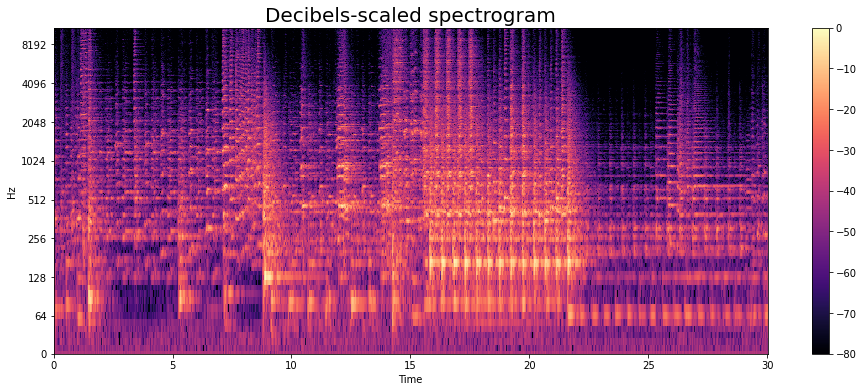

In [ ]:
# Inspect a single audio file
# https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/ComputerVision/spectrogram_analysis.ipynb
sample_path = 'Data/genres_original/jazz/jazz.00000.wav'
y, sample_rate = librosa.load(sample_path)
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print('Shape of D object:', np.shape(D))

# Convert amplitude spectrogram to Decibels-scaled spectrogram.

DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the spectogram.

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Decibels-scaled spectrogram', fontsize=20)
plt.show()

# Create folder with training, testing and validation sets

In [ ]:
# @title Helper functions (set device and plotting loss accuracy)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

In [ ]:
# Folders for training, test and set
# https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/ComputerVision/spectrogram_analysis.ipynb
spectrograms_dir = "Data/images_original/"
folder_names = ['Data/train/', 'Data/test/', 'Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:10]
  val_files = src_file_paths[10:20]
  train_files = src_file_paths[20:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))  

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

In [ ]:
# Training set
# Mixture code:
# https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/ComputerVision/spectrogram_analysis.ipynb
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0)

# Validation set
val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0)


#train_test_dir = ['train', 'val']
# Create full paths to access train and validation data
data_dir = "Data/"

data_transforms = {'train': transforms.Compose([transforms.ToTensor()]),
                   'val': transforms.Compose([transforms.ToTensor()]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=25,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Alternate solution to older code - will not work in this state
#dataloaders = [train_loader, val_loader]
#dataset_sizes = [len(dataloaders[x]) for x in [0,1]]

print(dataset_sizes)

{'train': 799, 'val': 100}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Load the pretrained model (VGG)

In [ ]:
 # @title Set device (GPU or CPU)
# NMA code
# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

device = set_device()

GPU is enabled in this notebook.


In [ ]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
# https://pytorch.org/vision/stable/models.html
# Load pretrained VGG
vgg16 = models.vgg16(pretrained=True)
n_classes = len(genres) # genres defined above - list of directories of different classes
# for name,layer in googlenet.named_parameters():
#   print("NAME:", name, "LAYER:", layer.shape)

# Freeze the network except the last layer
for param in vgg16.parameters():
    param.requires_grad = True # If True it will train

# Parameters of newly constructed modules have requires_grad=True by default
# Add on classifier

vgg16.classifier[6] = nn.Sequential(
                      nn.Linear(vgg16.classifier[3].in_features, 256),
                      nn.ReLU(), 
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train and evaluate

In [ ]:
# @title Train model function from PyTorch

# Original code from this tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_acc_list = []
    # train_loss, validation_loss = [], []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            num_examples = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                num_examples += inputs.size(0)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            # Different to tutorial, hardcoded dataset size
            # print(dataset_sizes) from above 
            
            #if phase == 'train':
            #    num_examples = len(train_loader) * len(next(iter(train_loader))[0]) 
            #else:
            #    num_examples = len(val_loader) * len(next(iter(val_loader))[0])
            print('number of examples in loader = ', num_examples)
            print(f'RUNNING LOSS: {running_loss}, RUNNING CORRECTS: {running_corrects}')

            epoch_loss = running_loss / num_examples
            print()
            epoch_acc = running_corrects.double() / num_examples

            epoch_acc_list.append(epoch_acc)
          
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # model = model.to('cuda')
    return model, epoch_acc_list

In [ ]:
# model trains - change num_epochs to increase training time
model_ft, epoch_acc_list = train_model(vgg16.to(device), criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


number of examples in loader =  799
RUNNING LOSS: 1788.4141166210175, RUNNING CORRECTS: 146

train Loss: 2.2383 Acc: 0.1827
number of examples in loader =  100
RUNNING LOSS: 202.9261589050293, RUNNING CORRECTS: 48

val Loss: 2.0293 Acc: 0.4800

Epoch 1/49
----------
number of examples in loader =  799
RUNNING LOSS: 1416.8610781431198, RUNNING CORRECTS: 286

train Loss: 1.7733 Acc: 0.3579
number of examples in loader =  100
RUNNING LOSS: 151.54108107089996, RUNNING CORRECTS: 48

val Loss: 1.5154 Acc: 0.4800

Epoch 2/49
----------
number of examples in loader =  799
RUNNING LOSS: 1163.9984279870987, RUNNING CORRECTS: 400

train Loss: 1.4568 Acc: 0.5006
number of examples in loader =  100
RUNNING LOSS: 130.99089860916138, RUNNING CORRECTS: 56

val Loss: 1.3099 Acc: 0.5600

Epoch 3/49
----------
number of examples in loader =  799
RUNNING LOSS: 961.1226243376732, RUNNING CORRECTS: 446

train Loss: 1.2029 Acc: 0.5582
number of examples in loader =  100
RUNNING LOSS: 124.07439649105072, RUNN

# Plot the validation accuracy

In [ ]:
def plot_loss_accuracy(epoch_acc_list):
  epochs = len(epoch_acc_list)


  # ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  plt.plot(list(range(epochs)), epoch_acc_list, label='Epoch Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Epoch vs Accuracy')
  plt.legend()
  plt.show()

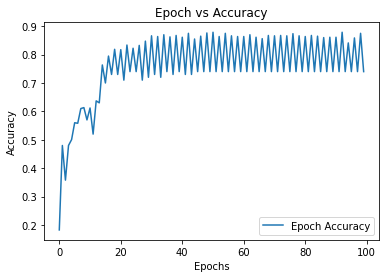

In [ ]:
plot_loss_accuracy(epoch_acc_list)

# Representation visualisation


In [ ]:
print_model = False
if print_model == True:
  print(model_ft)

In [ ]:
# @title Plot activations helper functions 
#

In [ ]:
# https://medium.com/analytics-vidhya/deep-dream-visualizing-the-features-learnt-by-convolutional-networks-in-pytorch-b7296ae3b7f

In [ ]:
3 # Create list of model layers:
list(map(lambda x: x[0], model_ft.named_children()))

['conv1',
 'maxpool1',
 'conv2',
 'conv3',
 'maxpool2',
 'inception3a',
 'inception3b',
 'maxpool3',
 'inception4a',
 'inception4b',
 'inception4c',
 'inception4d',
 'inception4e',
 'maxpool4',
 'inception5a',
 'inception5b',
 'avgpool',
 'dropout',
 'fc']

In [ ]:
# Create forward hook:

activation = {} # dictionary to store the activation of a layer
def create_hook(name):
 def hook(m, i, o):
   # copy the output of the given layer
   activation[name] = o
 
 return hook

# register a forward hook for layer inception4a
model_ft.inception4a.register_forward_hook(create_hook(‘4a’))

SyntaxError: ignored